# get_hrdps

This routine grabs the latest High Resolution Deterministic Prediction System (HRDPS) model data from MSC Datamart and outputs png plots into designated product folders for each ACMWF product.

**Datamart:**

https://eccc-msc.github.io/open-data/msc-data/nwp_hrdps/readme_hrdps_en/

https://dd.weather.gc.ca/model_hrdps/

**Outputs:**

Hourly Precipitation -> *BC/AB, South Coast, South Interior, Alberta Rockies, Precipitation Type*

12Hr Precipitation -> *South Coast, South Interior, Alberta Rockies*

Temperatures -> *Surface*


**Maintenance:**

For bug reports, suggestions, inquiries, contact Andrew.Loeppky@gmail.com

In [1]:
from herbie import Herbie
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.weight"] = "heavy"
from toolbox import EasyMap, pc
import cartopy.crs as ccrs
import cartopy.feature as feature
import pandas as pd

from matplotlib.patches import Rectangle
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pytz
import os, shutil
import json

import warnings

# supress because removal of old datafiles is handled outside herbie
warnings.filterwarnings("ignore")

from bmwflib import (
    clear_directory,
    get_var,
    plot_cities,
    make_figure,
    make_basemap,
    make_title,
)

%load_ext jupyter_black

 ╭─▌▌Herbie─────────────────────────────────────────────╮
 │ WARNING: Unable to create config file               │
 │      /Users/andrew/.config/herbie/config.toml        │
 │ Herbie will use standard default settings.           │
 │ Consider setting env variable HERBIE_CONFIG_PATH.    │
 ╰──────────────────────────────────────────────────────╯



In [ ]:
def plot_temps(fxx, ds, config):
    """
    plots 2m temperatures, saves hourly
    """
    fig, ax = make_figure()
    ax.set_extent([-140, -110, 46, 65])

    # basemap
    make_basemap(ax)

    # configure colormaps
    t_cmap = mpl.colors.ListedColormap(
        [
            "#FFFFFF",
            "#999999",
            "#490049",
            "#5F0060",
            "#7D007E",
            "#8E528E",
            "#1600FE",
            "#0066CB",
            "#00CCFF",
            "#FEFF99",
            "#FEFF49",
            "#FFD100",
            "#FE6600",
            "#FF3200",
            "#FE0066",
            "#660000",
            "#320000",
        ]
    )
    t_bounds = [
        -40,
        -35,
        -30,
        -25,
        -20,
        -15,
        -10,
        -5,
        -1,
        1,
        5,
        10,
        15,
        20,
        25,
        30,
        35,
        40,
    ]
    t_labels = [
        "<-40",
        "-35",
        "-30",
        "-25",
        "-20",
        "-15",
        "-10",
        "-5",
        "-1",
        "+1",
        "5",
        "10",
        "15",
        "20",
        "25",
        "30",
        "35",
        "40+",
    ]
    t_norm = mpl.colors.BoundaryNorm(t_bounds, t_cmap.N)

    # plot 2m temperature
    t2m = ax.pcolormesh(
        ds.longitude,
        ds.latitude,
        ds.t2m,
        cmap=t_cmap,
        norm=t_norm,
        antialiased=True,
        transform=pc,
        alpha=0.9,
    )

    # 2m temp colorbar
    fig.text(0.151, 0.689, "($^o$C)", color="black", size=15)
    fig.text(0.15, 0.69, "($^o$C)", color="white", size=15)

    t_cbar = fig.colorbar(
        t2m,
        cmap=t_cmap,
        norm=t_norm,
        ax=ax,
        spacing="uniform",
        shrink=0.6,
        location="left",
        aspect=18,
        anchor=(0.13, 0.25),
        pad=-0.16,
    )
    t_cbar.ax.set_yticks(t_bounds)
    t_cbar.ax.tick_params(
        labelsize=15,
        labelcolor="white",
        length=0,
        labelright=True,
        labelleft=False,
    )
    t_cbar.ax.set_yticklabels(t_labels)

    # cities
    plot_cities(ax)

    # title
    make_title(fig, ax, ds, "Temperature\n2 metres", offset=0.03)

    # save and close figure
    fig.savefig(
        os.path.join(
            config["plots"]["surf_temp"],
            f"temp2m_{ds.model}_{pd.Timestamp(ds.time.values).strftime('%Y_%_h_%d')}_{pd.Timestamp(ds.time.values).strftime('%H')}Z_P{fxx}",
        ),
        bbox_inches="tight",
    )
    fig.clf()

    return None

In [3]:
def plot_precip1hr(fxx, ds, config):
    """
    plots 1hr precip, saves hourly to the BC/AB, south coast,
    south interior, alberta rockies folders
    """

    def do_precip1h(fxx, ds, config, extent, save_path):
        """
        subfunction of plot_precip1hr designed to handle different
        map extents
        """
        fig, ax = make_figure()
        ax.set_extent(extent)

        # basemap
        make_basemap(ax)

        # plot precip rate
        pr_cmap = mpl.colors.ListedColormap(
            [
                "#99FF99",
                "#33FE32",
                "#00A702",
                "#017302",
                "#FEFE31",
                "#FECB00",
                "#FE6400",
                "#FE0000",
                "#FE0097",
            ]
        )
        pr_bounds = [0.1, 1, 2, 5, 7.5, 10, 15, 20, 25]
        pr_labels = ["0.1", "1", "2", "5", "7.5", "10", "15", "20", "25+"]
        pr_norm = mpl.colors.BoundaryNorm(pr_bounds, pr_cmap.N)
        pr = ax.pcolormesh(
            ds.longitude,
            ds.latitude,
            ds["APCP-Accum1h"].where(ds["APCP-Accum1h"] >= 0.1),
            cmap=pr_cmap,
            norm=pr_norm,
            antialiased=True,
            transform=pc,
        )

        # precip colorbar
        fig.text(0.142, 0.698, "(mm/h)", color="black", size=15)
        fig.text(0.14, 0.7, "(mm/h)", color="white", size=15)

        pr_cbar = fig.colorbar(
            pr,
            cmap=pr_cmap,
            norm=pr_norm,
            ax=ax,
            spacing="uniform",
            shrink=0.45,
            location="left",
            aspect=10,
            anchor=(0.14, 0.45),
            pad=-0.16,
        )
        pr_cbar.ax.tick_params(
            labelsize=15,
            labelcolor="white",
            length=0,
            labelright=True,
            labelleft=False,
        )
        pr_cbar.ax.set_yticklabels(pr_labels)

        # cities
        plot_cities(ax)

        # title
        make_title(fig, ax, ds, "Hourly Precipitation", offset=0.03)

        # save and close
        fig.savefig(save_path, bbox_inches="tight")
        fig.clf()

        return None

    # BC/AB
    path = (
        os.path.join(
            config["plots"]["hpcp_bcab"],
            f"pcp1hr_{ds.model}_{pd.Timestamp(ds.time.values).strftime('%Y_%_h_%d')}_{pd.Timestamp(ds.time.values).strftime('%H')}Z_P{fxx}",
        ),
    )
    do_precip1h(fxx, ds, config, [-140, -110, 46, 65], path)

    # South Coast
    path = os.path.join(
        config["plots"]["hpcp_southcoast"],
        f"pcp1hr_{ds.model}_{pd.Timestamp(ds.time.values).strftime('%Y_%_h_%d')}_{pd.Timestamp(ds.time.values).strftime('%H')}Z_P{fxx}",
    )
    do_precip1h(fxx, ds, config, [-129, -120, 47.5, 53], path)

    # South Interior
    fig = do_precip1h(fxx, ds, config, [-125, -113, 48.5, 56])
    fig.savefig(
        os.path.join(
            config["plots"]["hpcp_southint"],
            f"pcp1hr_{ds.model}_{pd.Timestamp(ds.time.values).strftime('%Y_%_h_%d')}_{pd.Timestamp(ds.time.values).strftime('%H')}Z_P{fxx}",
        ),
        bbox_inches="tight",
    )
    fig.clf()

    # Alberta Rockies
    fig = do_precip1h(fxx, ds, config, [-128, -111, 48.5, 59])
    fig.savefig(
        os.path.join(
            config["plots"]["hpcp_rockies"],
            f"pcp1hr_{ds.model}_{pd.Timestamp(ds.time.values).strftime('%Y_%_h_%d')}_{pd.Timestamp(ds.time.values).strftime('%H')}Z_P{fxx}",
        ),
        bbox_inches="tight",
    )
    fig.clf()

    return None

In [4]:
def plot_precip12hr(fxx, ds, config):
    """
    plots 1hr precip, saves hourly to the BC/AB, south coast,
    south interior, alberta rockies folders
    """
    fig, ax = make_figure()

    # basemap
    make_basemap(ax)

    # plot precip rate
    pr_cmap = mpl.colors.ListedColormap(
        [
            "#CDFFCC",
            "#13F08C",
            "#05CC35",
            "#009901",
            "#FEFF65",
            "#FF9935",
            "#FE6666",
            "#FE0000",
            "#990001",
            "#9900CC",
        ]
    )
    pr_bounds = [1, 2.5, 5, 15, 25, 50, 75, 100, 150, 200]
    pr_labels = ["1", "2.5", "5", "15", "25", "50", "75", "100", "150", "200+"]
    pr_norm = mpl.colors.BoundaryNorm(pr_bounds, pr_cmap.N)
    pr = ax.pcolormesh(
        ds.longitude,
        ds.latitude,
        ds["APCP-Accum12h"].where(ds["APCP-Accum12h"] >= 1),
        cmap=pr_cmap,
        norm=pr_norm,
        antialiased=True,
        transform=pc,
    )

    # precip colorbar
    fig.text(0.151, 0.699, "(mm)", color="black", size=10)
    fig.text(0.15, 0.7, "(mm)", color="white", size=10)

    pr_cbar = fig.colorbar(
        pr,
        cmap=pr_cmap,
        norm=pr_norm,
        ax=ax,
        spacing="uniform",
        shrink=0.45,
        location="left",
        aspect=10,
        anchor=(0.15, 0.45),
        pad=-0.16,
    )
    pr_cbar.ax.tick_params(
        labelsize=10,
        labelcolor="white",
        length=0,
        labelright=True,
        labelleft=False,
    )
    pr_cbar.ax.set_yticklabels(pr_labels)

    # cities
    plot_cities(ax)

    # title
    make_title(fig, ax, ds, "Total Precip - 12h", offset=0.03)

    # South Coast
    ax.set_extent([-129, -120, 47.5, 53])
    fig.savefig(
        os.path.join(
            config["plots"]["12hpcp_southcoast"],
            f"pcp12hr_{ds.model}_{pd.Timestamp(ds.time.values).strftime('%Y_%_h_%d')}_{pd.Timestamp(ds.time.values).strftime('%H')}Z_P{fxx}",
        )
    )
    fig.clf()

    # South Interior
    ax.set_extent([-125, -113, 48.5, 56])
    fig.savefig(
        os.path.join(
            config["plots"]["12hpcp_southint"],
            f"pcp12hr_{ds.model}_{pd.Timestamp(ds.time.values).strftime('%Y_%_h_%d')}_{pd.Timestamp(ds.time.values).strftime('%H')}Z_P{fxx}",
        )
    )
    fig.clf()

    # Alberta Rockies
    ax.set_extent([-128, -111, 48.5, 59])
    fig.savefig(
        os.path.join(
            config["plots"]["12hpcp_rockies"],
            f"pcp12hr_{ds.model}_{pd.Timestamp(ds.time.values).strftime('%Y_%_h_%d')}_{pd.Timestamp(ds.time.values).strftime('%H')}Z_P{fxx}",
        )
    )
    fig.clf()

    return None

In [5]:
def plot_precip_type(fxx, ds, config):
    """
    plots 1hr precip type, saves hourly to the /Precipitation Type directory
    """
    fig, ax = make_figure()
    ax.set_extent([-140, -110, 46, 65])

    # basemap
    make_basemap(ax)

    def do_ptype(ax, pr_cmap, ptype, anchor, label):
        """
        subfunction to plot precipitation type on ax

        1=Rain;
        2=Rain/snow;
        3=Freezing rain;
        4=Ice pellets;
        5=Snow;
        6=None;
        7=Drizzle;
        8=Freezing drizzle;
        9=Freezing rain/ice pellets
        """

        pr_bounds = [0.1, 0.5, 1, 3, 6]
        pr_labels = ["0.1", "0.5", "1.0", "3.0", "6.0"]
        pr_norm = mpl.colors.BoundaryNorm(pr_bounds, pr_cmap.N)
        pr = ax.pcolormesh(
            ds.longitude,
            ds.latitude,
            ds["APCP-Accum1h"]
            .where(ds["APCP-Accum1h"] >= 0.1)
            .where(ds["ptype"].astype(int) == ptype),
            cmap=pr_cmap,
            norm=pr_norm,
            antialiased=True,
            transform=pc,
        )

        pr_cbar = fig.colorbar(
            pr,
            cmap=pr_cmap,
            norm=pr_norm,
            ax=ax,
            label=label,
            spacing="uniform",
            shrink=0.075,
            location="left",
            aspect=2,
            anchor=anchor,
            pad=-0.14,
        )
        pr_cbar.ax.tick_params(
            labelsize=10,
            labelcolor="white",
            length=0,
            labelright=True,
            labelleft=False,
        )
        pr_cbar.ax.set_yticklabels(pr_labels)
        pr_cbar.ax.set_ylabel(
            label, rotation=90, labelpad=5, color="white", weight="bold", size=12
        )

        return None

    # plot rain
    rain_cmap = mpl.colors.ListedColormap(
        ["#00DE00", "#029A00", "#017701", "#024301", "#001601"]
    )
    do_ptype(ax, rain_cmap, 1, (0.8, 0.15), "Rain")

    # plot mixed precip
    mixed_cmap = mpl.colors.ListedColormap(
        ["#EDFE00", "#EDCC00", "#EEAA01", "#EE8800", "#EE6600"]
    )
    do_ptype(ax, mixed_cmap, 2, (0.7, 0.3), "Mixed Precip")

    # plot snow
    snow_cmap = mpl.colors.ListedColormap(
        ["#03EEFF", "#0275CE", "#025598", "#032264", "#010032"]
    )
    do_ptype(ax, snow_cmap, 5, (0.6, 0.45), "Snow")

    # plot freezing rain
    frain_cmap = mpl.colors.ListedColormap(
        ["#FEA9AA", "#FE6666", "#FE0000", "#CB0000", "#780000"]
    )
    do_ptype(ax, frain_cmap, 3, (0.5, 0.6), "Freezing Rain")

    # plot ice pellets
    ip_cmap = mpl.colors.ListedColormap(
        ["#FEA9FF", "#FC67FF", "#FF01FE", "#CA00CC", "#790075"]
    )
    do_ptype(ax, ip_cmap, 4, (0.4, 0.75), "Ice Pellets")

    # cities
    plot_cities(ax)

    # units
    fig.text(0.186, 0.719, "(mm)", color="black", size=15)
    fig.text(0.185, 0.72, "(mm)", color="white", size=15)

    # title
    make_title(fig, ax, ds, "Precipitation\nType", offset=0.07)

    fig.savefig(
        os.path.join(
            config["plots"]["hpcp_ptype"],
            f"ptype_{ds.model}_{pd.Timestamp(ds.time.values).strftime('%Y_%_h_%d')}_{pd.Timestamp(ds.time.values).strftime('%H')}Z_P{fxx}",
        ),
        bbox_inches="tight",
    )
    fig.clf()

    return None

In [6]:
def do_hrdps(run, fxx, config):
    """
    creates all hrdps dependent plots for forecast time fxx
    """
    # clear the hrdps data folder
    clear_dir = [clear_directory(file) for file in list(config["data"].values())]

    temp = get_var(run, "hrdps", fxx, "TMP", "AGL-2m")
    pcp1h = get_var(run, "hrdps", fxx, "APCP-Accum1h", "Sfc")
    ptype = get_var(run, "hrdps", fxx, "PTYPE", "Sfc")

    # plot 12hr accumulation after forecast hour 12 in 6 hr increments
    if (fxx >= 12) and (fxx % 6 == 0):
        pcp12h = get_var(run, "hrdps", fxx, "APCP-Accum12h", "Sfc")
        ds = xr.merge([temp, pcp1h, pcp12h, ptype])
        plot_precip12hr(fxx, ds, config)
    else:
        ds = xr.merge([temp, pcp1h, ptype])

    # convert temps from kelvin to degC
    ds["t2m"] -= 273.15

    # generate plots
    plot_temps(fxx, ds, config)
    plot_precip1hr(fxx, ds, config)
    plot_precip_type(fxx, ds, config)

    return ds

In [7]:
def main(tstep=range(1, 49, 1)):
    """
    main function to generate all hrdps plots for a forecast run
    (default 48h with 1h increments)
    """
    # time of last model run (0000, 0600, 1200, 1800 Z)
    now = pd.Timestamp.utcnow().floor("12h").tz_localize(None)

    # config determines the directories in which to save each graphic
    with open("..//config/hrdps_config.json") as f:
        config = json.load(f)

    clear_dir = [clear_directory(file) for file in list(config["plots"].values())]
    ds = [do_hrdps(now, fxx, config) for fxx in tstep]

    return ds

✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-12 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None
👨🏻‍🏭 Created directory: [/Users/andrew/data/hrdps/20250612]
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-12 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2025-Jun-12 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


AttributeError: 'tuple' object has no attribute 'write'

<Figure size 1500x1500 with 0 Axes>

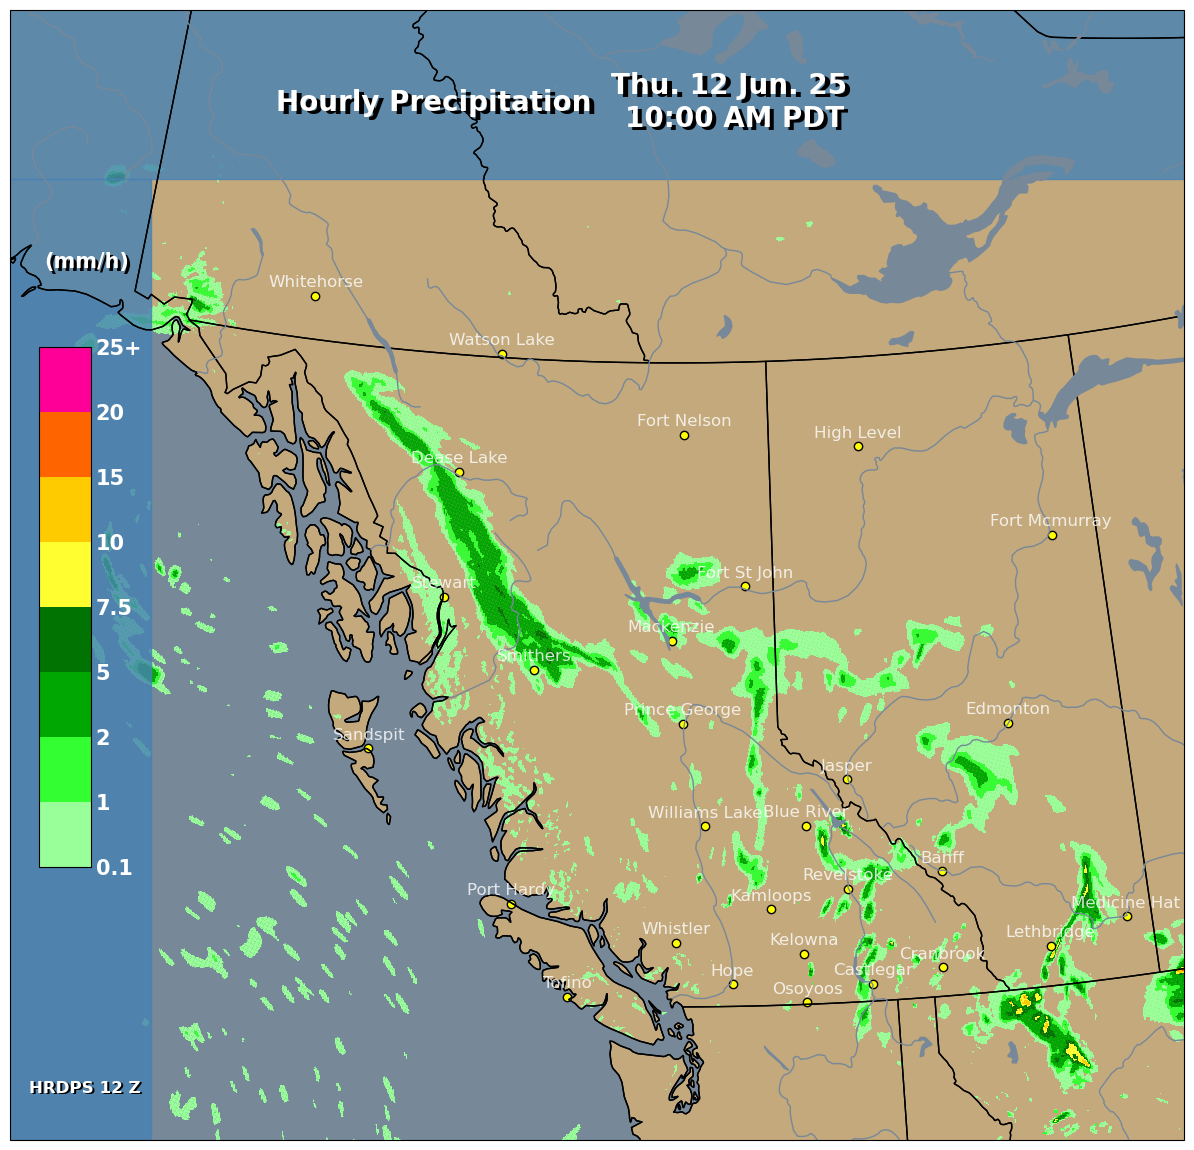

In [8]:
if __name__ == "__main__":
    ds = main([5])

In [ ]:
os.path.join("file1", "file2")